# PPO-Based Portfolio Rebalancing with Reinforcement Learning

In this notebook, we build a **Reinforcement Learning-based portfolio rebalancer** using the **Proximal Policy Optimization (PPO)** algorithm. The goal is to dynamically adjust asset allocations across a portfolio of stocks to **maximize long-term returns** while considering **risk and transaction costs**.

### Key Features:
- Multi-asset support (Top 5 Tech Stocks)
- Custom Gym environment
- Continuous action space (allocation weights)
- Reward = log return with transaction cost penalty
- Comparison with Buy-and-Hold and Equal Weight strategies

## Install Dependencies

In [1]:
!pip install -q gymnasium==0.29.1 stable-baselines3==2.2.1 shimmy yfinance matplotlib pandas numpy ta

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.7/181.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.3 MB/s eta 0:00:00
E

## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.callbacks import EvalCallback
import ta

## Step 1: Fetch & Prepare Stock Data

In [3]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
start_date = '2020-01-01'
end_date = '2025-01-01'

def download_data(tickers, start, end):
    """
    Downloads adjusted close price data for given tickers.

    Returns:
        DataFrame of shape (T, N) where T is time and N is number of assets.
    """
    df = yf.download(tickers, start=start, end=end, auto_adjust=True)

    if isinstance(df.columns, pd.MultiIndex):
        # Multi-ticker: use only 'Close' prices
        close_prices = df['Close']
        close_prices = close_prices[tickers]  # preserve column order
    else:
        # Single ticker
        close_prices = df[['Close']]
        close_prices.columns = tickers

    return close_prices.dropna()

# Use the function
price_df = download_data(tickers, start_date, end_date)


[*********************100%***********************]  5 of 5 completed


## Step 2: Create Custom Gym Environment

In [4]:
class PortfolioEnv(gym.Env):
    """
    Portfolio rebalancing environment compatible with Gymnasium API.

    Observation: for each asset: [relative_price, ma5, ma20, volatility]
    Action: allocation weights for each asset (sum to 1)
    """
    metadata = {'render_modes': ['human']}

    def __init__(self, prices: pd.DataFrame, window_size: int = 20, transaction_fee: float = 0.002):
        super().__init__()
        self.prices = prices.reset_index(drop=True)
        self.window_size = window_size
        self.transaction_fee = transaction_fee

        # Number of assets
        self.num_assets = prices.shape[1]
        # Define action and observation space
        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(self.num_assets,), dtype=np.float32)
        obs_dim = self.num_assets * 4  # relative, ma5, ma20, vol
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)

        # Internal state
        self.current = None
        self.weights = None
        self.prev_weights = None
        self._reset_state()

    def _reset_state(self):
        self.current = self.window_size
        self.weights = np.ones(self.num_assets) / self.num_assets
        self.prev_weights = self.weights.copy()

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self._reset_state()
        obs = self._get_obs()
        info = {}
        return obs, info

    def step(self, action):
        w = np.clip(action, 0, 1)
        w_sum = w.sum()
        if w_sum <= 0:
            w = np.ones_like(w) / len(w)
        else:
            w = w / w_sum

        prev_price = self.prices.iloc[self.current - 1].values
        curr_price = self.prices.iloc[self.current].values
        price_relatives = curr_price / (prev_price + 1e-8)

        port_return = np.dot(w, price_relatives)
        trans_cost = self.transaction_fee * np.sum(np.abs(w - self.prev_weights))

        reward = np.log(port_return + 1e-8) - trans_cost

        self.prev_weights = self.weights.copy()
        self.weights = w
        self.current += 1

        terminated = self.current >= len(self.prices)
        truncated = False

        obs = self._get_obs()
        info = {}

        return obs, float(reward), terminated, truncated, info

    def _get_obs(self):
        if self.current < self.window_size or self.current > len(self.prices):
            return np.zeros(self.observation_space.shape, dtype=np.float32)

        window = self.prices.iloc[self.current - self.window_size:self.current]
        close = window.values

        rel = (close[-1] / (close[-2] + 1e-8)).clip(0, 10)
        ma5 = np.mean(close[-5:], axis=0)
        ma20 = np.mean(close, axis=0)
        vol = np.std(close, axis=0)

        features = np.concatenate([rel, ma5, ma20, vol]).astype(np.float32)
        return features

    def render(self):
        pass

## Step 3: Train PPO Agent

In [ ]:
# --- Step 1: Define proper environment factory ---
def make_env(price_data):
    def _init():
        return PortfolioEnv(price_data)
    return _init

# --- Step 2: Split data ---
train_df = price_df['2020-01-01':'2023-12-31']
test_df  = price_df['2024-01-01':]

# --- Step 3: Create vectorized and normalized environments ---
train_env = DummyVecEnv([make_env(train_df)])
train_env = VecNormalize(train_env, norm_obs=True, norm_reward=True, clip_obs=10.0)

eval_env = DummyVecEnv([make_env(test_df)])
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=True, training=False)
eval_env.obs_rms = train_env.obs_rms  # sync normalization statistics

# --- Step 4: Define evaluation callback ---
callback = EvalCallback(
    eval_env,
    best_model_save_path='./logs/',
    log_path='./logs/',
    eval_freq=10_000,
    deterministic=True,
    render=False
)

# --- Step 5: Define PPO agent ---
model = PPO(
    "MlpPolicy",
    train_env,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    ent_coef=0.01,
    verbose=0
)

# --- Step 6: Train ---
model.learn(total_timesteps=500_000, callback=callback)
model.save("ppo_portfolio_rebalancer")

# Saving normalization statistics
train_env.save("ppo_portfolio_vecnormalize.pkl")

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=10000, episode_reward=0.06 +/- 0.00
Episode length: 232.00 +/- 0.00
New best mean reward!
Eval num_timesteps=20000, episode_reward=0.35 +/- 0.00
Episode length: 232.00 +/- 0.00
New best mean reward!
Eval num_timesteps=30000, episode_reward=0.64 +/- 0.00
Episode length: 232.00 +/- 0.00
New best mean reward!
Eval num_timesteps=40000, episode_reward=1.41 +/- 0.00
Episode length: 232.00 +/- 0.00
New best mean reward!
Eval num_timesteps=50000, episode_reward=1.54 +/- 0.00
Episode length: 232.00 +/- 0.00
New best mean reward!
Eval num_timesteps=60000, episode_reward=1.40 +/- 0.00
Episode length: 232.00 +/- 0.00
Eval num_timesteps=70000, episode_reward=1.16 +/- 0.00
Episode length: 232.00 +/- 0.00
Eval num_timesteps=80000, episode_reward=1.09 +/- 0.00
Episode length: 232.00 +/- 0.00
Eval num_timesteps=90000, episode_reward=1.15 +/- 0.00
Episode length: 232.00 +/- 0.00
Eval num_timesteps=100000, episode_reward=0.80 +/- 0.00
Episode length: 232.00 +/- 0.00
Eval num_timesteps=

## Step 4: Evaluate on Test Data

In [ ]:
def evaluate_agent(model, df, vecnorm_path="ppo_portfolio_vecnormalize.pkl"):
    """
    Evaluate a trained PPO model on test data (DataFrame df),
    using the same VecNormalize statistics.
    Returns a 1D array of portfolio values over time.
    """
    # 1) Create and wrap the test env
    eval_env = DummyVecEnv([lambda: PortfolioEnv(df)])
    eval_env = VecNormalize.load(vecnorm_path, eval_env)
    eval_env.training = False
    eval_env.norm_reward = False

    # 2) Reset: gives obs batch of shape (1, obs_dim)
    obs_batch = eval_env.reset()
    # If reset returns (obs, info), unpack:
    if isinstance(obs_batch, tuple):
        obs_batch, _ = obs_batch
    # extract single env obs vector:
    obs = obs_batch[0]

    portfolio_values = [10000.0]
    done = [False]

    while not done[0]:
        # 3) predict on the batch
        action_batch, _ = model.predict(obs_batch, deterministic=True)
        # step the env with the batch action
        obs_batch, reward_batch, done, _ = eval_env.step(action_batch)

        # extract scalars
        reward = float(reward_batch[0])
        obs = obs_batch[0]

        # update portfolio
        portfolio_values.append(portfolio_values[-1] * np.exp(reward))

    return np.array(portfolio_values)


# Usage:
rl_vals = evaluate_agent(model, test_df)

##Step 5: Comparison with Equal-Weight and Buy-and-Hold

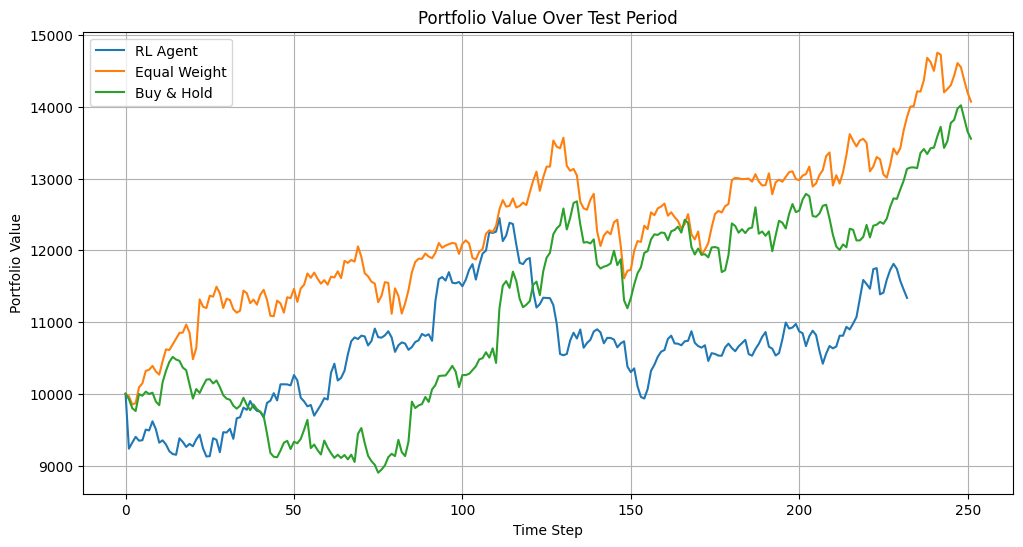

In [ ]:
# --- 1) Updated simulate_baseline with a guard ---
def simulate_baseline(prices, strat):
    """
    Simulate portfolio value over time using a baseline strategy.
    Raises an error if 'prices' is empty.
    """
    if prices.shape[0] == 0:
        raise ValueError("Empty price series passed to simulate_baseline.")

    # build weights
    if strat == "equal_weight":
        w = np.ones(prices.shape[1]) / prices.shape[1]
    elif strat == "buy_and_hold":
        w = np.zeros(prices.shape[1])
        w[0] = 1.0
    else:
        raise ValueError(f"Unknown strategy: {strat}")

    # initial shares from 10,000 capital
    init_prices = prices.iloc[0].values
    shares = (w * 10000.0) / (init_prices + 1e-8)

    # compute portfolio value each day
    vals = (prices.values * shares.reshape(1, -1)).sum(axis=1)
    return vals

# --- 2) Simulate baselines ---
eq_vals = simulate_baseline(test_df, "equal_weight")
bh_vals = simulate_baseline(test_df, "buy_and_hold")

# --- 3) Plot alongside RL results ---
plt.figure(figsize=(12,6))
plt.plot(rl_vals, label="RL Agent")
plt.plot(eq_vals, label="Equal Weight")
plt.plot(bh_vals, label="Buy & Hold")
plt.title("Portfolio Value Over Test Period")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.show()

## Step 6: Conclusion & Future Work
- The PPO agent learned to dynamically rebalance a portfolio across 5 tech stocks.

- Further improvements could include:
  - Incorporating more technical indicators
  - Using a recurrent (LSTM) policy
  - Extending to more assets or ETFs
  - Accounting for slippage, leverage, or macroeconomic signals

---
 **Next Steps:**
 - Try training on different asset groups (e.g., energy, commodities, or small caps)

- Combine the RL signal with traditional finance heuristics (e.g., value/momentum filters)

- Explore ensemble agents or meta-learning to generalize across regimes

